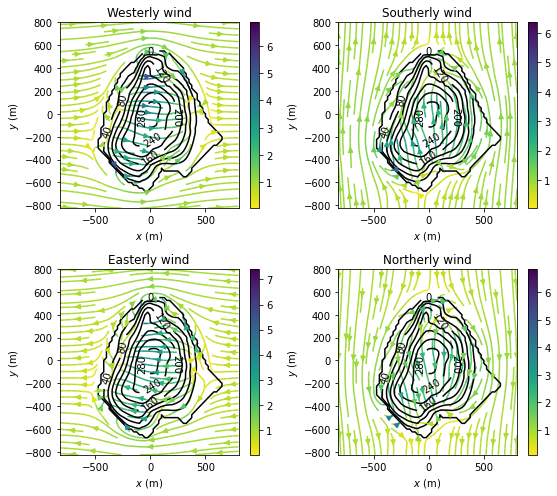

In [9]:
"""
Linear model for turbulent flow over low hills derived
from Jackson and Hunt (1975), Mason and Sykes (1979)
"""
import matplotlib.pyplot as plt
import numpy as np
from scipy.fftpack import fft2,fftshift,ifft2,ifftshift
from scipy.special import kv

def wind_model(n,zr):
    # Fourier transform
    Fz = fft2(zr)
    Fz = fftshift(Fz)
    # Wavenumbers and modified Bessel functions
    k = (2*np.pi/(n*dx))*np.arange(-n/2,n/2)       
    m = (2*np.pi/(n*dx))*np.arange(-n/2,n/2)
    bu = 1 - kv(0,2*np.sqrt(1j*L0*k*zu/l))/kv(0,2*np.sqrt(1j*L0*k*z0/l))
    bv = 1 - kv(0,2*np.sqrt(2*1j*L0*k*zu/l))/kv(0,2*np.sqrt(2*1j*L0*k*z0/l))
    bu[int(n/2)] = 0
    bv[int(n/2)] = 0
    # Fourier components of u and v
    Fu = np.zeros_like(Fz)
    Fv = np.zeros_like(Fz)
    for i in range(n):
        for j in range(n):
            r = np.sqrt(k[j]**2 + m[i]**2)
            if r>0:
                Fu[i,j] = a*bu[j]*(k[j]**2/r)*Fz[i,j]
                Fv[i,j] = a*bv[j]*(k[j]*m[i]/r)*Fz[i,j]
    # Inverse Fourier transform
    Fu = ifftshift(Fu)
    Fv = ifftshift(Fv)
    ur = 1 + np.real(ifft2(Fu))
    vr = np.real(ifft2(Fv))
    windr = np.sqrt(ur**2 + vr**2)
    return ur,vr,windr

def plot_wind(u,v,wind,z,title):
    x = np.arange(-128,128)*dx
    y = np.arange(-128,128)*dx
    plt.streamplot(x[95:161],y[95:161],u[95:161,95:161],v[95:161,95:161],
                   color=wind[95:161,95:161],cmap='viridis_r')
    plt.colorbar()
    cs = plt.contour(x[95:161],y[95:161],z[95:161,95:161],colors='k')
    plt.clabel(cs,fmt='%d')
    plt.xlabel('$x$ (m)')
    plt.ylabel('$y$ (m)')
    plt.title(title)

# Parameters
topo_file = 'data/AilsaCraig.txt' # Topography file name
dx = 25                      # Grid spacing (m)
L0 = 1000.                   # Horizontal length scale (m)
z0 = 0.01                    # Surface roughness length (m)
zu = 2.                      # Wind measurement height (m)

# Iteration to find the inner region thickness l (m)
l = (z0/8)*(L0/z0)**0.9
for i in range(10):
    l = 2*0.16*L0/np.log(l/z0)
a = (np.log(L0/z0))**2/(np.log(l/z0)*np.log(zu/z0))

# Read the topography file and find size
z = np.loadtxt(topo_file)
n = z.shape[0]

plt.figure(figsize=(8,7))

# Westerly wind
plt.subplot(221)
u, v, wind = wind_model(n,z)
plot_wind(u,v,wind,z,'Westerly wind')

# Southerly wind
plt.subplot(222)
zr = np.flipud(z.T)
ur, vr, windr = wind_model(n,zr)
u = - np.fliplr(vr.T)
v = np.fliplr(ur.T)
wind = np.fliplr(windr.T)
plot_wind(u,v,wind,z,'Southerly wind')

# Easterly wind
plt.subplot(223)
zr = np.flipud(np.fliplr(z))
ur, vr, windr = wind_model(n,zr)
u = - np.flipud(np.fliplr(ur))
v = - np.flipud(np.fliplr(vr))
wind = np.flipud(np.fliplr(windr))
plot_wind(u,v,wind,z,'Easterly wind')

# Northerly wind
plt.subplot(224)
zr = np.fliplr(z.T)
ur, vr, windr = wind_model(n,zr)
u = np.flipud(vr.T)
v = - np.flipud(ur.T)
wind = np.flipud(windr.T)
plot_wind(u,v,wind,z,'Northerly wind')

plt.tight_layout()